# Regression analysis with Python: `statsmodels`, `bambi`, `pymc3`, and `arviz`

This workshop's goal&mdash;which is facilitated by this Jupyter notebook&mdash;is to give attendees the confidence to conduct regression analyses with `python` for their research projects.

[statsmodels](https://www.statsmodels.org/stable/index.html) is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration

[bambi](https://bambinos.github.io/bambi/main/index.html) is a high-level Bayesian model-building interface written in Python

[pymc3](https://docs.pymc.io/en/v3/) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process

[arviz](https://arviz-devs.github.io/arviz/index.html) is a Python package for exploratory analysis of Bayesian models

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html), as well as a few other examples, and go through the various steps of conducting regression analyses in both [classical](https://www.statsmodels.org/stable/regression.html) and [Bayesian](https://bambinos.github.io/bambi/main/notebooks/getting_started.html) frameworks.  Hopefully, you will come away feeling confident you can use `python` to conduct regression analyses for your research projects.

## Table of Contents

1. Logistic regression with `statsmodels`

  - A single predictor
  - A continuous predictor
  - Two predictors (no interaction)
  - Two predictors (with interaction)

2. Aggregated binomial regression with `statsmodels`

3. Poisson regression with `statsmodels`

4. Negative binomial (gamma-Poisson) regression with `statsmodels`

5. Logistic regression with `bambi`

  - A single predictor
  - A continuous predictor
  - Two predictors (no interaction)
  - Two predictors (with interaction)
  - Model comparison

## Install specific packages

In [ ]:
!pip install bambi

In [ ]:
!pip install statsmodels==0.13.2

In [ ]:
!pip install pandas==1.3.5

## Load packages

In [4]:
from datetime import datetime
from math import exp

import random
import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy import optimize
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import palettable

import patsy
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pymc3 as pm
from pymc3 import glm
import theano

import bambi as bmb

import arviz as az

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Analysis last performed on 05/14/2022.

## Check package versions

In [5]:
pd.__version__

'1.3.5'

In [6]:
sm.__version__

'0.13.2'

In [7]:
bmb.__version__

'0.7.1'

## List pre-defined style sheets provided by [`matplotlib`](https://matplotlib.org/stable/tutorials/introductory/customizing.html#using-style-sheets):

In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository]().  For this example, we're working with the `wells` dataset from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html).

In [8]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
wells = pd.read_csv('https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Arsenic/data/wells.csv')
wells

,switch,arsenic,dist,dist100,assoc,educ,educ4
0,1,2.36,16.826000,0.16826,0,0,0.00
1,1,0.71,47.321999,0.47322,0,0,0.00
2,0,2.07,20.966999,0.20967,0,10,2.50
3,1,1.15,21.486000,0.21486,0,12,3.00
4,1,1.10,40.874001,0.40874,1,14,3.50
...,...,...,...,...,...,...,...
3015,0,0.52,19.347000,0.19347,1,5,1.25
3016,0,1.08,21.386000,0.21386,1,3,0.75
3017,0,0.51,7.708000,0.07708,0,4,1.00
3018,0,0.64,22.841999,0.22842,0,3,0.75


In [9]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
wells.isna().sum()

switch     0
arsenic    0
dist       0
dist100    0
assoc      0
educ       0
educ4      0
dtype: int64

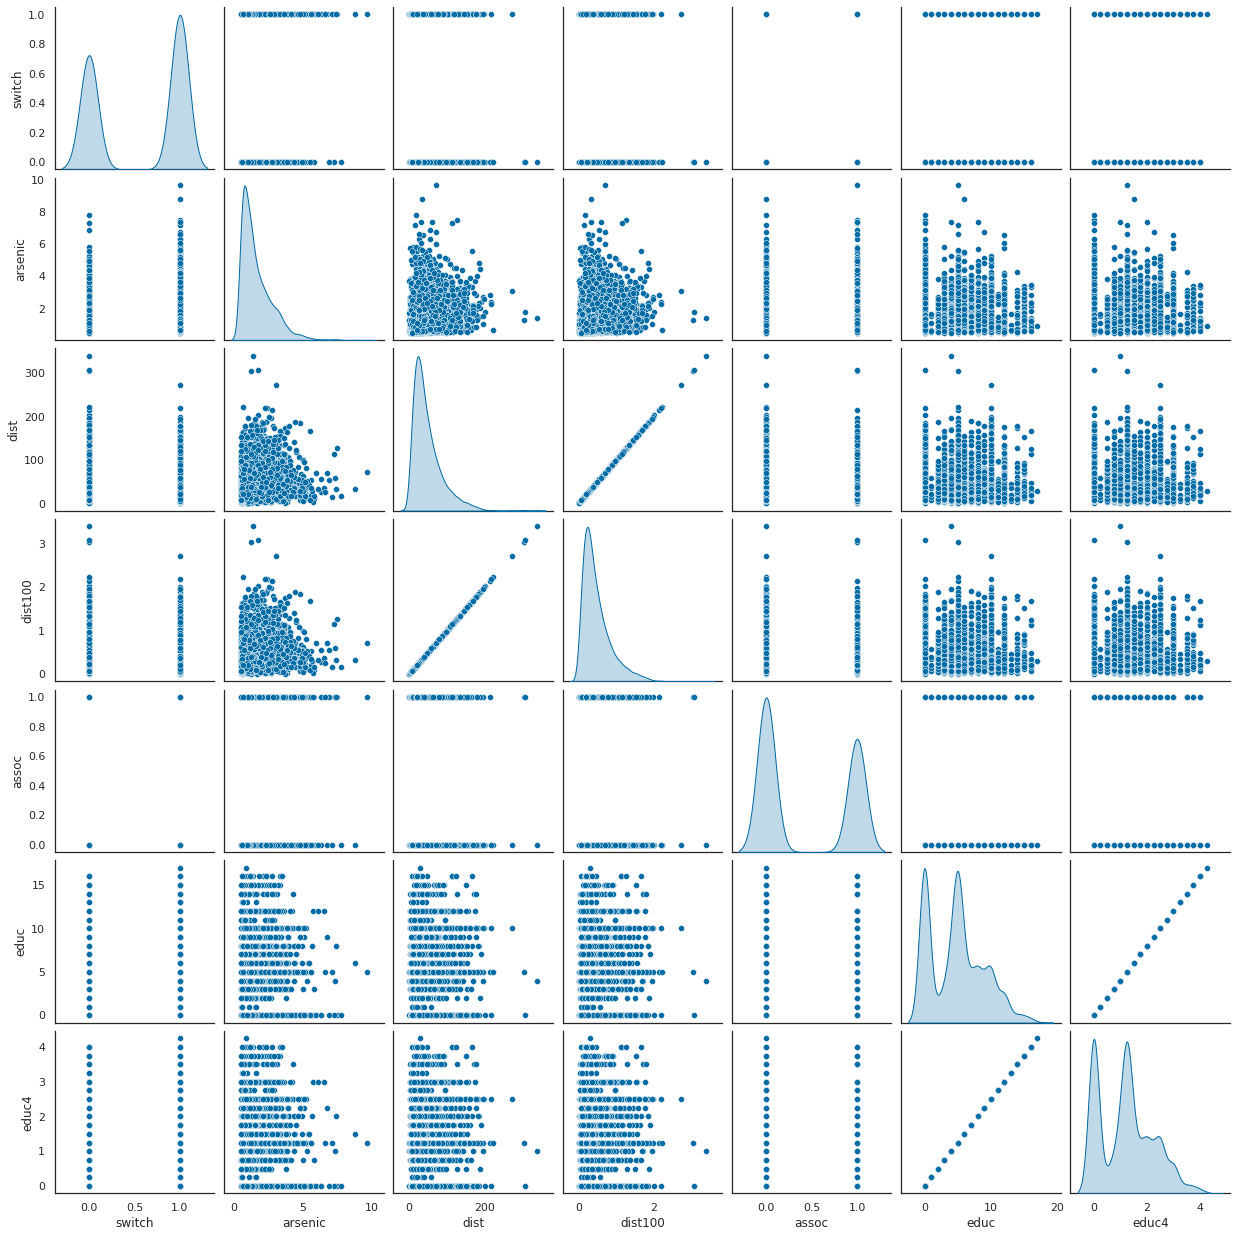

In [18]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(wells, diag_kind='kde');

In [19]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
wells.describe().round(decimals=2)  # transpose().round(decimals=1)

,switch,arsenic,dist,dist100,assoc,educ,educ4
count,3020.00,3020.00,3020.00,3020.00,3020.00,3020.00,3020.00
mean,0.58,1.66,48.33,0.48,0.42,4.83,1.21
std,0.49,1.11,38.48,0.38,0.49,4.02,1.00
min,0.00,0.51,0.39,0.00,0.00,0.00,0.00
25%,0.00,0.82,21.12,0.21,0.00,0.00,0.00
50%,1.00,1.30,36.76,0.37,0.00,5.00,1.25
75%,1.00,2.20,64.04,0.64,1.00,8.00,2.00
max,1.00,9.65,339.53,3.40,1.00,17.00,4.25


In [20]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
print(sm.stats.Describe(wells.values).summary(stats='all'))

                            Summary Statistics                            
          Col 0     Col 1     Col 2    Col 3    Col 4     Col 5    Col 6  
--------------------------------------------------------------------------
obs         3020.     3020.     3020.    3020.    3020.     3020.    3020.
mean       0.5752     1.657     48.33   0.4833   0.4228     4.828    1.207
std        0.4943     1.107     38.47   0.3847   0.4940     4.017    1.004
min         0.000    0.5100    0.3870 0.003870    0.000     0.000    0.000
max         1.000     9.650     339.5    3.395    1.000     17.00    4.250
ptp         1.000     9.140     339.1    3.391    1.000     17.00    4.250
var        0.2444     1.226     1480.   0.1480   0.2440     16.13    1.008
mode_val    1.000    0.5200     107.7    1.077    0.000     0.000    0.000
mode_bin    1737.     33.00     8.000    8.000    1743.     889.0    889.0
median      1.000     1.300     36.76   0.3676    0.000     5.000    1.250
uss         1737. 1.199e+

## Exercise: Refer to the [seaborn documentation](https://seaborn.pydata.org/tutorial.html) and create some additional distribution plots for the variables in the dataset.

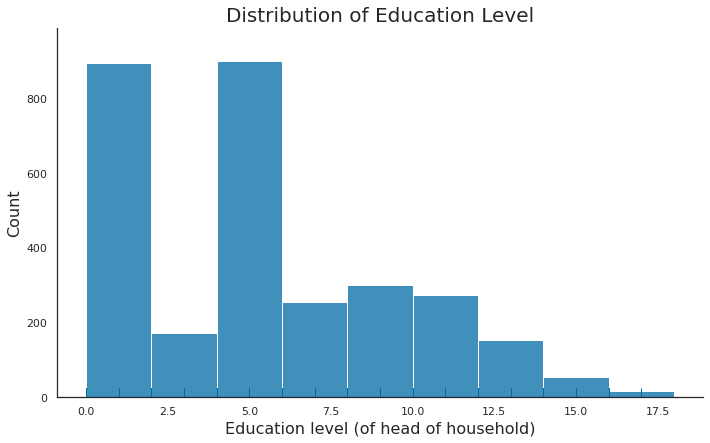

In [14]:
# For example:
sns.displot(wells, x='educ', rug=True, binwidth=2, height=6, aspect=10/6)
plt.xlabel('Education level (of head of household)', fontsize=16);
plt.ylabel('Count', fontsize=16);
plt.title('Distribution of Education Level', fontsize=20);

In [23]:
# Your turn: Create a distribution plot for a variable in the wells dataset using seaborn



In [24]:
# Your turn: Create a distribution plot for a variable in the wells dataset using seaborn



## Exercise: Refer to the [plotly documentation](https://plotly.com/python/) and create some additional distribution plots for the variables in the dataset.

In [25]:
# For example:
p1 = px.histogram(wells, x='educ',
                  labels=dict(educ='Education level (of head of household)', count='Count'),
                  #title='Distribution of Mom IQ',
                  height=500, width=800)

p1.update_layout(
    title={
        'text': 'Distribution of Education Level',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'auto'},
        bargap=0.15)
p1.update_yaxes(title_text='Count')

p1.show();

In [26]:
# Your turn: Create a distribution plot for a variable in the wells dataset using plotly



In [27]:
# Your turn: Create a distribution plot for a variable in the wells dataset using plotly



# statsmodels (R-style formula interface)

## A single predictor

We start by modeling the probability of switching wells (actually, the log-odds of switching wells) with an intercept (a column of 1s), which summarizes the overall mean log-odds of switching wells.

We can interpret the coefficient estimates using evaluations of the inverse logit function.  As shown by the coefficient for the Intercept, the overall mean probability of switching is inverse-logit(0.3) = **0.58**.  Thus, the model estimates an overall **58%** probability of switching.

In [10]:
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/discrete_choice_example.html

# Fit regression model
fit0 = smf.logit('switch ~ 1', data=wells).fit()

# Inspect results
print(fit0.summary())

Optimization terminated successfully.
         Current function value: 0.681805
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3019
Method:                           MLE   Df Model:                            0
Date:                Sat, 14 May 2022   Pseudo R-squ.:               7.829e-11
Time:                        17:04:26   Log-Likelihood:                -2059.0
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3030      0.037      8.230      0.000       0.231       0.375


In [11]:
# Inspect results
print(fit0.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: switch           AIC:              4120.0992
Date:               2022-05-14 17:04 BIC:              4126.1122
No. Observations:   3020             Log-Likelihood:   -2059.0  
Df Model:           0                LL-Null:          -2059.0  
Df Residuals:       3019             LLR p-value:      nan      
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     4.0000                                      
------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    0.3030     0.0368   8.2299   0.0000   0.2308   0.3751



Let's double-check that the result of regressing `switch` on an intercept does indeed produce the mean of the `switch` column (the proportion of 1s in the column).

In [30]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html

# Proportion switch = 1 in the dataset
np.round(expit(fit0.params), decimals=4)

Intercept    0.5752
dtype: float64

Let's double-check the calculation using the data in the dataset:

- Using the `mean` function

- Using the count of 1s divided by the total count

- The count of 1s

- The total count

In [103]:
# Proportion switch = 1 in the dataset
( np.round(wells['switch'].mean(), decimals=4), 
  np.round(len(wells.loc[wells['switch'] == 1, 'switch']) / len(wells['switch']), decimals=4),

# Number of observations where switch = 1
  len(wells.loc[wells['switch'] == 1, 'switch']),

# Total number of observations
  len(wells['switch']) )

(0.5752, 0.5752, 1737, 3020)

The `fit0` object has many useful attributes.  Type `dir(fit0)` for a full list of attributes.

Let's see how we can extract specific pieces of information from the fitted model object.  Here, we extract the log-likelihood and Akaike information criterion (AIC) values for the model.

In [32]:
# Log-Likelihood and Akaike information criterion (AIC)
( np.round(fit0.llf, decimals=1) , np.round(fit0.aic, decimals=1) )

(-2059.0, 4120.1)

### A single continuous predictor

Now let's model the probabilitiy of switching wells, given a continuous predictor, distance (in meters) to hte closest known safe well.

We fit the model using `statsmodels`, which allows users to fit statistical models using `R`-style formulas.  Internally, `statsmodels` uses the `patsy` package to convert formulas and data to the matrices that are used in model fitting.

The coefficient for `dist` is --0.006, which seems low, but this is misleading since distance is measure in meters, so this coefficient corresponds to the difference between, say, a house that is 90 meters away from the nearest safe well and a house that is 91 meters away.

In [33]:
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html
# SOURCE: https://www.statsmodels.org/stable/examples/notebooks/generated/discrete_choice_example.html

# Fit regression model
fit1 = smf.logit('switch ~ 1 + dist', data=wells).fit()

# Inspect results
print(fit1.summary())

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 May 2022   Pseudo R-squ.:                 0.01017
Time:                        21:21:00   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6060      0.060     10.047      0.000       0.488       0.724
dist          -0.0062      0.

The `fit1` object has many useful attributes.  Type `dir(fit1)` for a full list of attributes.

In [34]:
dir(fit1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_endog_name',
 '_get_robustcov_results',
 '_use_t',
 'aic',
 'bic',
 'bse',
 'conf_int',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'f_test',
 'fittedvalues',
 'get_margeff',
 'initialize',
 'k_constant',
 'llf',
 'llnull',
 'llr',
 'llr_pvalue',
 'load',
 'mle_retvals',
 'mle_settings',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'pred_table',
 'predict',
 'prsquared',
 'pvalues',
 'remove_data',
 'resid_dev',
 'resid_generalized',
 'resid_pearson',
 'resid_response',
 'save',
 'scale',
 'set_null_options',
 'summary'

In [35]:
# Inspect results (version 2)
print(fit1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.010     
Dependent Variable: switch           AIC:              4080.2378 
Date:               2022-05-12 21:21 BIC:              4092.2639 
No. Observations:   3020             Log-Likelihood:   -2038.1   
Df Model:           1                LL-Null:          -2059.0   
Df Residuals:       3018             LLR p-value:      9.7978e-11
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      0.6060    0.0603  10.0474  0.0000   0.4878   0.7242
dist          -0.0062    0.0010  -6.3831  0.0000  -0.0081  -0.0043



The `fit1` object has many useful attributes.  For example, we can extract parameter estimates and fitted values by typing:

In [36]:
fit1.params

Intercept    0.605959
dist        -0.006219
dtype: float64

In [37]:
pd.concat([fit1.predict(wells['dist']), expit(fit1.fittedvalues)], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
0,0.622770,0.622770
1,0.577293,0.577293
2,0.616701,0.616701
3,0.615938,0.615938
4,0.587047,0.587047
...,...,...
3015,0.619080,0.619080
3016,0.616085,0.616085
3017,0.635995,0.635995
3018,0.613941,0.613941


### Histogram of distance to the nearest safe well

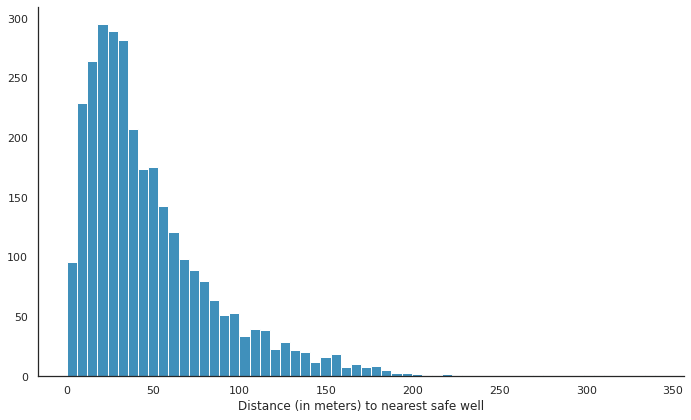

In [38]:
g = sns.displot(wells.dist, height=6, aspect=10/6)
g.set_axis_labels('Distance (in meters) to nearest safe well', '')
g.set_titles('');

Viewing the histogram, it seems more reasonable to rescale distance in 100-meter units.

In [14]:
# Rescale distance into 100-meter units
wells['dist100'] = wells['dist'] / 100.0

Re-fitting the logistic regression yields:

In [15]:
# Fit regression model
fit2 = smf.logit('switch ~ 1 + dist100', data=wells).fit()

# Inspect results
print(fit2.summary())

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 May 2022   Pseudo R-squ.:                 0.01017
Time:                        17:06:20   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6060      0.060     10.047      0.000       0.488       0.724
dist100       -0.6219      0.

In [16]:
fit2.params

Intercept    0.605959
dist100     -0.621882
dtype: float64

In [17]:
pd.concat([fit2.predict(wells['dist100']), expit(fit2.fittedvalues)], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
0,0.622770,0.622770
1,0.577293,0.577293
2,0.616701,0.616701
3,0.615938,0.615938
4,0.587047,0.587047
...,...,...
3015,0.619080,0.619080
3016,0.616085,0.616085
3017,0.635995,0.635995
3018,0.613941,0.613941


We can interpret the coefficient estimates using evaluation of the inverse logit function.  Our model is:

Pr(switch) = inverse-logit(0.61 -- 0.62 * dist100)

The constant term can be interpreted when dist100 = 0, in which case the probability of switching is inverse-logit(0.61) = **0.65**.  Thus, the model estimates a **65%** probability of switching if you live right next to an existing safe well.

In [18]:
np.round( expit(fit2.params['Intercept']), 2)

0.65

We can evaluate the predictive difference with respect to dist100 by computing the derivative at the average value of dist100 in the dataset, which is **0.48** (that is, **48 meters**).

The value of the linear predictor here is 0.61 -- 0.62 * 0.48 = **0.31**, and so the slope of the curve at this point is --0.62e^0.31 / (1 + e^0.31)^2 = **-0.15**.  Thus, adding 1 to dist100 -- that is, adding 100 meters to the distance to the nearest safe well -- corresponds to a *negative* difference in the probability of switching of about **15%**.

More quickly, the divide-by-4 rule gives us --0.62 / 4 = --0.15.  This comes out the same, to two decimal places, as the result from calculating the derivative, because in this case the curve happens to pass through the 50% point right in the middle of the data.

In [110]:
# Average distance to the nearest safe well (48 meters)
np.round(wells.dist100.mean(), 2)

0.48

In [113]:
# Value of the linear predictor at this point (48 meters to nearest safe well)
np.round( fit2.params['Intercept'] + (fit2.params['dist100'] * wells.dist100.mean()) , 2)

0.31

In [117]:
# Slope of the curve at this point (48 meters to nearest safe well)
value_of_linear_predictor_at_48_meters = fit2.params['Intercept'] + (fit2.params['dist100'] * wells.dist100.mean())

slope_of_curve_at_this_point = fit2.params['dist100'] * exp(value_of_linear_predictor_at_48_meters) / (1 + exp(value_of_linear_predictor_at_48_meters))**2

np.round(slope_of_curve_at_this_point, 2)

-0.15

In [19]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html

fit2_margeff = fit2.get_margeff()
print(fit2_margeff.summary())

        Logit Marginal Effects       
Dep. Variable:                 switch
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dist100       -0.1498      0.023     -6.558      0.000      -0.195      -0.105


Thus, adding 1 to dist100 -- that is, adding 100 meters to the distance to the nearest safe well -- corresponds to a negative difference in the probability of switching of about 15%.

### `seaborn` 

[`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html): Plot data and a logistic regression model fit (`logistic=True`)

Graphical expression of the fitted logistic regression, Pr(switching wells) = inverse-logit(0.61 -- 0.62 * dist100), with (jittered) data overlaid.  The predictor dist100 is dist/100: distance to the nearest safe well in 100-meter units.

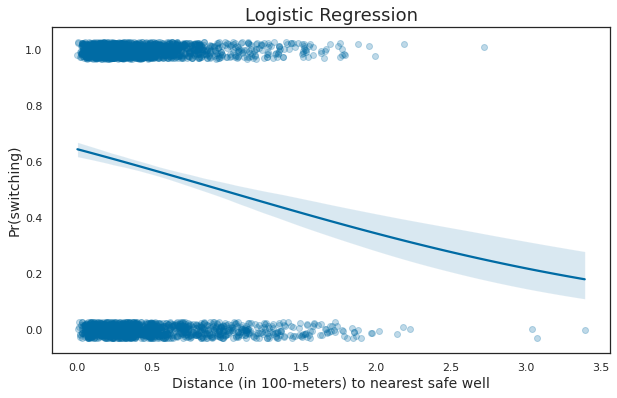

In [43]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.regplot.html

fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x="dist100", y="switch", data=wells, 
            logistic=True, n_boot=500, y_jitter=.03, 
            scatter_kws={'alpha': 0.25}, # Set transparency to 50%
            ax=ax)
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.set_title('Logistic Regression', fontsize=18);

The values in the `switch` column are 1s and 0s, so many of the points overlap.  Let's use a function that jitters the points (slightly shifts their positions) to make it easier to see individual points.

In [44]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

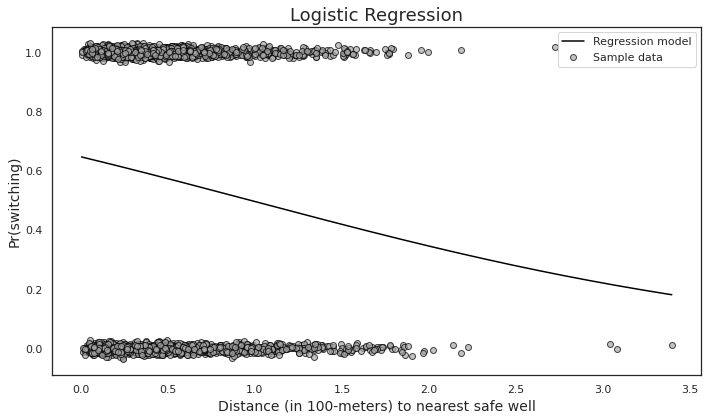

In [45]:
# SOURCE: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
x = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)
y = fit2.predict(pd.DataFrame({'dist100': x}))
f = interp1d(x, y, kind = "cubic")
xnew = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(xnew, ynew, linestyle='-', color='black', label='Regression model')

ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

## Two predictors

### No interaction

Now we extend the well-switching example by adding the arsenic level of the existing well as a regression input.  At the levels present in the Bangladesh drinking water, the health risks from arsenic are roughly proportional to exposure, and so we would expect switching to be more likely from wells with high arsenic levels.

### Histogram of arsenic levels (arsenic levels exceeding **0.5** are considered "unsafe")

Arsenic concentration in units of hundreds of micrograms per liter

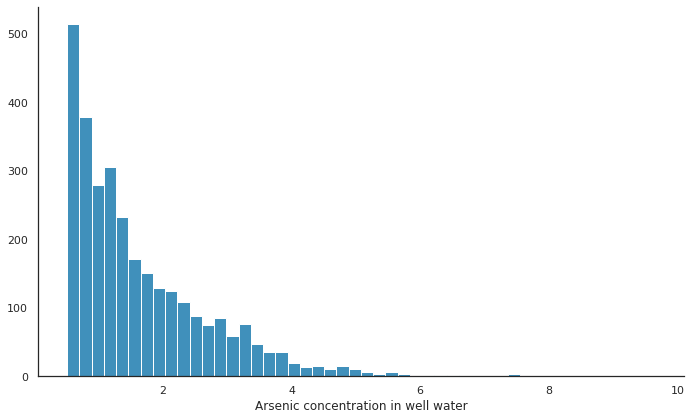

In [46]:
g = sns.displot(wells.arsenic, height=6, aspect=10/6)
g.set_axis_labels('Arsenic concentration in well water', '')
g.set_titles('');

Here is the logistic regression predicing switching given distance to the nearest safe well and arsenic level in the existing well.

We fit the model using `statsmodels`, which allows users to fit statistical models using `R`-style formulas.  Internally, `statsmodels` uses the `patsy` package to convert formulas and data to the matrices that are used in model fitting.

In [20]:
# Fit regression model
fit3 = smf.logit('switch ~ 1 + dist100 + arsenic', data=wells).fit()

# Inspect results
print(fit3.summary())

Optimization terminated successfully.
         Current function value: 0.650773
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3017
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 May 2022   Pseudo R-squ.:                 0.04551
Time:                        17:15:48   Log-Likelihood:                -1965.3
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 1.995e-41
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0027      0.079      0.035      0.972      -0.153       0.158
dist100       -0.8966      0.

Thus, comparing two wells with the same arsenic level, every 100 meters in distance to the nearest safe well corresponds to a *negative* difference of **0.90** in the logit probability of switching.  Similarly, a difference of 1 in arsenic concentration corresponds toa **0.46** *positive* difference in the logit probability of switching.

For a quick interpretation, we divide each of the coefficients by 4: thus, 100 meters more in distance corresponds to an approximately **22%** *lower* probability of switching, and 1 unit more in arsenic concentration corresponds to approximately 11% *positive* difference in switching probability.

In [21]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html

fit3_margeff = fit3.get_margeff()
print(fit3_margeff.summary())

        Logit Marginal Effects       
Dep. Variable:                 switch
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dist100       -0.2063      0.023     -9.014      0.000      -0.251      -0.161
arsenic        0.1060      0.009     12.044      0.000       0.089       0.123


### Fitted logistic regression of probability of switching from an unsafe well as a function of two variables, plotted as a function of distance to nearest safe well.  Arsenic level is held constant at different representative values

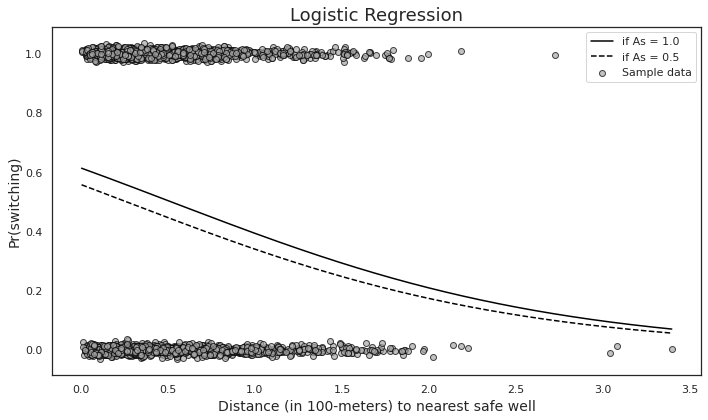

In [48]:
x = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)

# If arsenic level = 1.0
y1 = fit3.predict(pd.DataFrame({'dist100': x, 'arsenic': np.ones_like(x)}))
f1 = interp1d(x, y1, kind = "cubic")

# If arsenic level = 0.5 (pt5)
ypt5 = fit3.predict(pd.DataFrame({'dist100': x, 'arsenic': [0.5] * len(x)}))
fpt5 = interp1d(x, ypt5, kind = "cubic")

xnew = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)

# Interpolate line values for arsenic levels = 1.0 and 0.5
y1new = f1(xnew)
ypt5new = fpt5(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
# Arsenic level = 1.0
plt.plot(xnew, y1new,   linestyle='-',  color='black', label='if As = 1.0')
# Arsenic level = 0.5
plt.plot(xnew, ypt5new, linestyle='--', color='black', label='if As = 0.5')

ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

### Fitted logistic regression of probability of switching from an unsafe well as a function of two variables, plotted as a function of arsenic level of existing well.  Distance to nearest safe well is held constant at different representative values

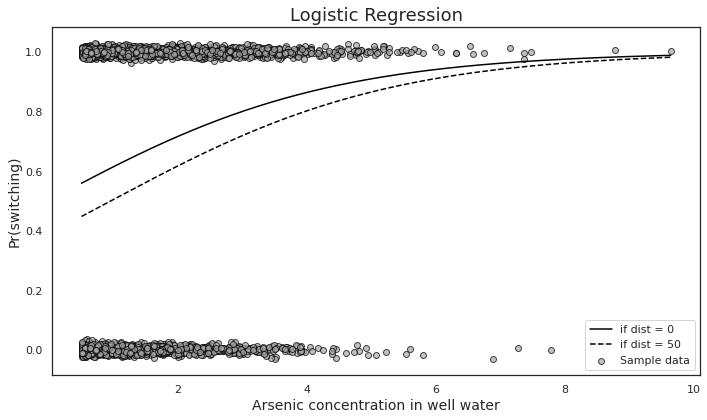

In [49]:
x = np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 1000)

# If distance = 0 meters
y1 = fit3.predict(pd.DataFrame({'dist100': np.zeros_like(x), 'arsenic': x}))
f1 = interp1d(x, y1, kind = "cubic")

# If distance = 50 meters (50 / 100 = 0.5)
ypt5 = fit3.predict(pd.DataFrame({'dist100': [0.5] * len(x), 'arsenic': x}))
fpt5 = interp1d(x, ypt5, kind = "cubic")

xnew = np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 1000)

# Interpolate line values for distance = 0 and 50 meters
y1new = f1(xnew)
ypt5new = fpt5(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(wells.arsenic, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
# Distance = 0 meters
plt.plot(xnew, y1new,   linestyle='-',  color='black', label='if dist = 0')
# Distance = 50 meters
plt.plot(xnew, ypt5new, linestyle='--', color='black', label='if dist = 50')

ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Arsenic concentration in well water', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

### Interaction

We continue the well-switching example by adding the interaction between the two predictors.  To understand the numbers in the table, we use the following tricks:

- Evaluating predictions and interactions at the mean of the data, which have average values of 0.48 for dist100 and 1.66 for arsenic (that is, a mean distance of 48 meters to the nearest safe well, and a mean arsenic level of 1.66 among the unsafe wells)

- Dividing by 4 to get approximate predictive differences on the probability scale



In [22]:
# Fit regression model
fit4 = smf.logit('switch ~ 1 + dist100 + arsenic + dist100:arsenic', data=wells).fit()

# Inspect results
print(fit4.summary())

Optimization terminated successfully.
         Current function value: 0.650270
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3016
Method:                           MLE   Df Model:                            3
Date:                Sat, 14 May 2022   Pseudo R-squ.:                 0.04625
Time:                        17:16:59   Log-Likelihood:                -1963.8
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 4.830e-41
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1479      0.118     -1.258      0.208      -0.378       0.083
dist100       

Now we can interpret the regression coefficients in turn:

***Constant term***: inverse-logit(--0.15) = 0.47 is the estimated probability of switching, if the distance to the nearest safe well is 0 and the arsenic level of the current well is 0.  This is an impossible condition (since arsenic levels all exceed 0.5 in our set of unsafe wells), so we do not try to interpret the constant term.  Instead, we can evaluate the prediction at the average values of dist100 = 0.48 and arsenic = 1.66, where the probability of switching is inverse-logit(--0.15 -- 0.58 * 0.48 + 0.56 * 1.66 -- 0.18 * 0.48 * 1.66) = **0.59**.

***Coefficient for distance***: this corresponds to comparing two wells that differ by 1 in dist100, if the arsenic level is 0 for both wells.  Once again, we should not try to interpret this.  Instead, we can look at the average value, arsenic = 1.66, where distance has a coefficient of --0.58 -- 0.18 * 1.66 = --0.88 on the logit scale.  To quickly interpret this on the probability scale, we divide by 4: --0.88 / 4 = --0.22.  Thus, at the mean level of arsenic in the data, each 100 meters of distance corresponds to an approximate **22%** *negative* difference in probability of switching.

***Coefficient for arsenic***: this corresponds to comparing two wells that differ by 1 in arsenic, if the distance to the nearest safe well is 0 for both.  Again, this is not so interpretable, so instead ew evaluate the comparison at the average value for distance, dist100 = 0.48, where arsenic has a coefficient of 0.56 -- 0.18 * 0.48 = 0.47 on the logit scale.  To quickly interpret this on the probability scale, we divide by 4: 0.47 / 4 = 0.12.  Thus, at the mean level of distance in the data, each additional unit of arsenic corresponds to an approximate **12%** *positive* difference in probability of switching.

***Coefficient for the interaction term***: this can be interpreted in two ways.  Looking from one direction, for each additional unit of arsenic, the value --0.18 is added to the coefficient for distance.  We have already seen that the coeffcient for distance is --0.88 at the average level of arsenic, and so we can understand the interaction as saying that the importance of distance as a predictor *increases* for households with higher existing arsenic levels.

Looking at it the other way, for each additional 100 meters of distance to the nearest well, the value --0.18 is added to the coefficient for arsenic.  We have already seen that the coefficient for distance is 0.47 at the average distance to nearest safe well, and so we can understand the interaction as saying that the importance of arsenic as a predictor *decreases* for households that are farther from existing safe wells.

### Fitted logistic regression of probability of switching from an unsafe well as a function of distance to nearest safe well and arsenic level of existing well, for the model with interactions.  Arsenic level is held constant at different representative values

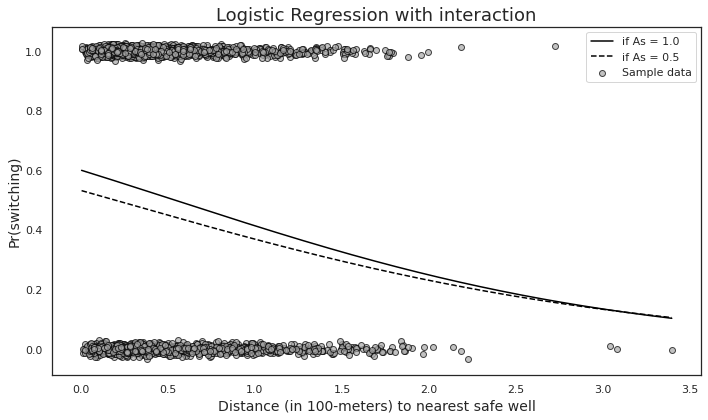

In [51]:
x = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)

# If arsenic level = 1.0
y1 = fit4.predict(pd.DataFrame({'dist100': x, 'arsenic': np.ones_like(x)}))
f1 = interp1d(x, y1, kind = "cubic")

# If arsenic level = 0.5 (pt5)
ypt5 = fit4.predict(pd.DataFrame({'dist100': x, 'arsenic': [0.5] * len(x)}))
fpt5 = interp1d(x, ypt5, kind = "cubic")

xnew = np.linspace(wells['dist100'].min(), wells['dist100'].max(), 1000)

# Interpolate line values for arsenic levels = 1.0 and 0.5
y1new = f1(xnew)
ypt5new = fpt5(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
# Arsenic level = 1.0
plt.plot(xnew, y1new,   linestyle='-',  color='black', label='if As = 1.0')
# Arsenic level = 0.5
plt.plot(xnew, ypt5new, linestyle='--', color='black', label='if As = 0.5')

ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression with interaction', fontsize=18)

fig.tight_layout();

### Fitted logistic regression of probability of switching from an unsafe well as a function of distance to nearest safe well and arsenic level of existing well, for the model with interactions.  Distance to nearest safe well is held constant at different representative values

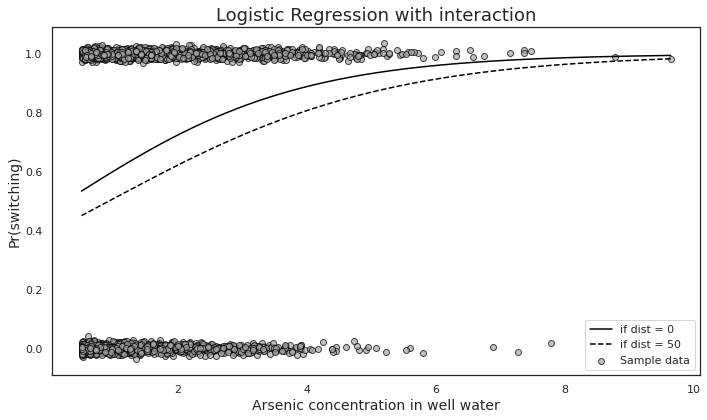

In [52]:
x = np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 1000)

# If distance = 0 meters
y1 = fit4.predict(pd.DataFrame({'dist100': np.zeros_like(x), 'arsenic': x}))
f1 = interp1d(x, y1, kind = "cubic")

# If distance = 50 meters (50 / 100 = 0.5)
ypt5 = fit4.predict(pd.DataFrame({'dist100': [0.5] * len(x), 'arsenic': x}))
fpt5 = interp1d(x, ypt5, kind = "cubic")

xnew = np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 1000)

# Interpolate line values for distance = 0 and 50 meters
y1new = f1(xnew)
ypt5new = fpt5(xnew)

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(wells.arsenic, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
# Distance = 0 meters
plt.plot(xnew, y1new,   linestyle='-',  color='black', label='if dist = 0')
# Distance = 50 meters
plt.plot(xnew, ypt5new, linestyle='--', color='black', label='if dist = 50')

ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Arsenic concentration in well water', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression with interaction', fontsize=18)

fig.tight_layout();

## statsmodels (API interface)

In addition to supporting specifying models using `R`-style formulas, `statsmodels` also supports specifying models as `numpy` arrays.

To fit most of the models with this format, you will need to create two design matrices:
* The first is a matrix of endogenous variable(s) (i.e. dependent, response, regressand, etc.)
* The second is a matrix of exogenous variable(s) (i.e. independent, predictor, regressor, etc.)

With this format, by default, `statsmodels` does not add a column of ones to the matrix of exogenous predictor variables (to represent the Intercept), so we use [`add_constant`](https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html) to add the columns of ones to our set of predictor variables.

In [24]:
# SOURCE: https://www.statsmodels.org/stable/gettingstarted.html
# Tools: add_constant https://www.statsmodels.org/stable/api.html

y = wells['switch']
X = wells['dist']
X = sm.add_constant(X)

# Describe regression model
model1 = sm.Logit(y,X)

# Fit regression model
results1 = model1.fit()

# Inspect results
print(results1.summary())

Optimization terminated successfully.
         Current function value: 0.674874
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 switch   No. Observations:                 3020
Model:                          Logit   Df Residuals:                     3018
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 May 2022   Pseudo R-squ.:                 0.01017
Time:                        17:18:08   Log-Likelihood:                -2038.1
converged:                       True   LL-Null:                       -2059.0
Covariance Type:            nonrobust   LLR p-value:                 9.798e-11
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6060      0.060     10.047      0.000       0.488       0.724
dist          -0.0062      0.

In [54]:
results1.params

const    0.605959
dist    -0.006219
dtype: float64

In [55]:
pd.concat([results1.predict(X), expit(results1.fittedvalues)], axis=1).rename({0: 'Predicted', 1: 'Inverse Logit(Fitted)'}, axis=1)

,Predicted,Inverse Logit(Fitted)
0,0.622770,0.622770
1,0.577293,0.577293
2,0.616701,0.616701
3,0.615938,0.615938
4,0.587047,0.587047
...,...,...
3015,0.619080,0.619080
3016,0.616085,0.616085
3017,0.635995,0.635995
3018,0.613941,0.613941


In [25]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html

res1_margeff = results1.get_margeff()
print(res1_margeff.summary())

        Logit Marginal Effects       
Dep. Variable:                 switch
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dist          -0.0015      0.000     -6.558      0.000      -0.002      -0.001


## Aggregated binomial

The `UCBadmit` dataset contains graduate school admissions to 6 different academic departments at UC Berkeley.  The `admit` column indicates the number offered admission.  The `reject` column indicates the opposite decision.  The `applications` column is just the sum of `admit` and `reject`.  Each application has a 0 or 1 outcome for admission, but since these outcomes have been aggregated by department and gender, there are only 12 rows.  These 12 rows however represent 4526 applications, the sum of the `applications` column.  So there is a lot of data here -- counting the rows in the data table is no longer a sensible way to assess sample size.  We could split these data apart into 0/1 Bernoulli trials, then there would be 4526 rows in the dataset.

In [30]:
UCBadmit_url = 'https://raw.githubusercontent.com/cbrownley/NYU-Python-Workshop/main/data/UCBadmit.csv'

UCBadmit = pd.read_csv(UCBadmit_url, sep=';')
UCBadmit.rename(columns={'applicant.gender': 'applicant_gender'}, inplace=True)
UCBadmit

,dept,applicant_gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [33]:
# SOURCE: https://predictivehacks.com/logistic-regression-on-aggregate-data-python/

# Fit aggregated binomial regression model
fit_m11_7 = smf.glm('admit + reject ~ applicant_gender - 1', data=UCBadmit, family=sm.families.Binomial()).fit()

# Inspect results
print(fit_m11_7.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     ['admit', 'reject']   No. Observations:                   12
Model:                             GLM   Df Residuals:                       10
Model Family:                 Binomial   Df Model:                            1
Link Function:                   Logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -426.27
Date:                 Sat, 14 May 2022   Deviance:                       783.61
Time:                         17:35:25   Pearson chi2:                     715.
No. Iterations:                      4   Pseudo R-squ. (CS):             0.9996
Covariance Type:             nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
applicant_gend

This model answers the question: *What are the average probabilities of admission for women and men, across all departments?*

In [42]:
print('The average probabilities of admission for women and men, across all departments, are {} and {}, respectively.  The log-odds difference, {}, is positive, corresponding to a higher probability of admission for male applicants.  On the probability scale, the difference is about {}%.  \n\nDoes this result contain evidence of gender bias in admissions?'.format(
np.round( expit(fit_m11_7.params['applicant_gender[female]']), 2) ,
np.round( expit(fit_m11_7.params['applicant_gender[male]']), 2) ,
np.round( fit_m11_7.params['applicant_gender[male]'], 2) - np.round( fit_m11_7.params['applicant_gender[female]'], 2) , 
np.round( expit(fit_m11_7.params['applicant_gender[male]']) - expit(fit_m11_7.params['applicant_gender[female]']), 2) ) )

The average probabilities of admission for women and men, across all departments, are 0.3 and 0.45, respectively.  The log-odds difference, 0.61, is positive, corresponding to a higher probability of admission for male applicants.  On the probability scale, the difference is about 0.14%.  

Does this result contain evidence of gender bias in admissions?


In [66]:
# SOURCE: Statistical Rethinking, 2nd Ed. Page 344
pg = UCBadmit.groupby(['dept', 'applicant_gender'])['applications'].sum() / UCBadmit.groupby('dept')['applications'].sum()
pg.unstack().T.round(2)

dept,A,B,C,D,E,F
applicant_gender,,,,,,
female,0.12,0.04,0.65,0.47,0.67,0.48
male,0.88,0.96,0.35,0.53,0.33,0.52


The rates of admission vary a lot across departments.  Furthermore, women and men applied to different departments.  These are the proportions of all applications in each departmetn that are from either men or women.  Department A receives 88% of its applications from men.  Department E receives 33% from men.  The departments with a larger proportion of women applicants are also those with lower overall admissions rates.

## Poisson regression

Binomial GLMs are appropriate when the outcome is a count from zero to some known upper bound.  But often the upper bound isn't known.  Instead the counts never get close to any upper limit.  For example, if we go fishing and return with 17 fish, what was the theoretical maximum?  Whatever it is, it isn't in our data.

It turns out that the binomial model works here, provided we squint at it the right way.  When a binomial distribution has a very small probability of an event *p* and a very large number of trials *N*, then it takes on a special shape.  The expected value of a binomial distribution is just *Np*, and its variance is *Np(1-p)*.  But when *N* is very large and *p* is very small, then these are *approximately the same*.

In [69]:
# SOURCE: https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html
y = np.random.binomial(n=1000, p=1/1000, size=10000)
(np.mean(y) , np.var(y))

(0.9997, 0.9910999100000001)

This is a special shape of the binomial.  This special shape is known as the **Poisson distribution**, and it is useful because it allows us to model binomial events for which the number of trials *N* is unknown or uncountably large.

In [72]:
roaches_url = 'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Roaches/data/roaches.csv'

roaches = pd.read_csv(roaches_url, usecols=['y', 'roach1', 'treatment', 'senior', 'exposure2'])

# Rescale
roaches['roach1'] = roaches['roach1'] / 100.

roaches

,y,roach1,treatment,senior,exposure2
0,153,3.0800,1,0,0.800000
1,127,3.3125,1,0,0.600000
2,7,0.0167,1,0,1.000000
3,7,0.0300,1,0,1.000000
4,0,0.0200,1,0,1.142857
...,...,...,...,...,...
257,0,0.0000,0,1,1.485714
258,0,0.0000,0,1,1.000000
259,0,0.0000,0,1,1.000000
260,171,0.0000,0,1,1.000000


In [78]:
# SOURCE: https://cran.r-project.org/web/packages/rstanarm/vignettes/count.html
# SOURCE: https://avehtari.github.io/ROS-Examples/Roaches/roaches.html

# Fit Poisson regression (with offset)
fit1_pois = smf.glm('y ~ roach1 + treatment + senior', data=roaches, family=sm.families.Poisson(), 
                    offset=np.log(roaches['exposure2'])).fit()

# Inspect results
print(fit1_pois.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  262
Model:                            GLM   Df Residuals:                      258
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6092.0
Date:                Sat, 14 May 2022   Deviance:                       11429.
Time:                        18:46:20   Pearson chi2:                 1.69e+04
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0892      0.021    145.486      0.0

## Negative binomial (gamma-Poisson) regression

To illustrate the use of a different model, here we will instead try **negative binomial** regression, which is also used for overdispersed or zero-inflated count data.  Unlike the Poisson distribution, the negative binomial distribution allows the (conditional) mean and variance of y to differ.

In [89]:
# SOURCE: https://cran.r-project.org/web/packages/rstanarm/vignettes/count.html
# SOURCE: https://avehtari.github.io/ROS-Examples/Roaches/roaches.html

# Fit Negative Binomial regression (with offset)
fit1_nb = smf.glm('y ~ roach1 + treatment + senior', data=roaches, 
                  family=sm.families.NegativeBinomial(), 
                  offset=np.log(roaches['exposure2'])).fit()

# Inspect results
print(fit1_nb.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  262
Model:                            GLM   Df Residuals:                      258
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1006.3
Date:                Sat, 14 May 2022   Deviance:                       766.10
Time:                        19:27:33   Pearson chi2:                 1.15e+03
No. Iterations:                    19   Pseudo R-squ. (CS):             0.5856
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8499      0.114     25.027      0.0

# Bambi: a high-level Bayesian model-building interface written in Python

## A single predictor

In [56]:
# SOURCE: https://bambinos.github.io/bambi/main/notebooks/model_comparison.html

# Initialize the model
model2_bmb = bmb.Model("switch ~ dist100", wells, family="bernoulli")

# Inspect model object
model2_bmb

Formula: switch ~ dist100
Family name: Bernoulli
Link: logit
Observations: 3020
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.0142)
    dist100 ~ Normal(mu: 0.0, sigma: 6.4982)

In [57]:
model2_bmb.build()

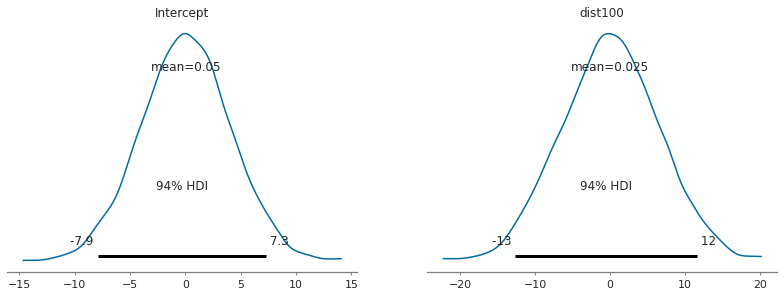

In [58]:
model2_bmb.plot_priors();

In [59]:
print(model2_bmb.backend.model)

Intercept ~ Normal
  dist100 ~ Normal
   switch ~ Bernoulli


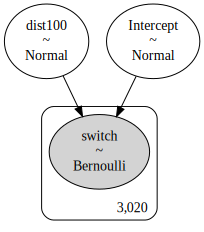

In [60]:
model2_bmb.graph()

In [61]:
fit2_bmb = model2_bmb.fit() # draws=5000, chains=4, cores=None
fit2_bmb

Modeling the probability that switch==1
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [dist100, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

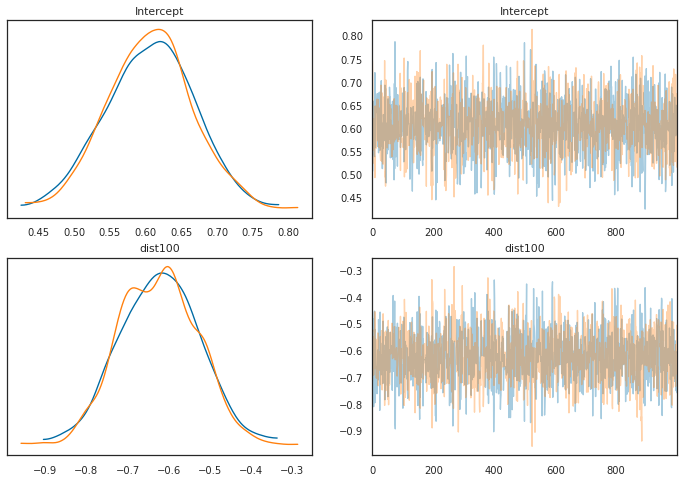

In [62]:
az.plot_trace(fit2_bmb, compact=False, figsize=(12,8));

In [63]:
az.summary(fit2_bmb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.606,0.060,0.493,0.717,0.001,0.001,1885.0,1574.0,1.0
dist100,-0.624,0.097,-0.807,-0.453,0.002,0.002,1865.0,1437.0,1.0


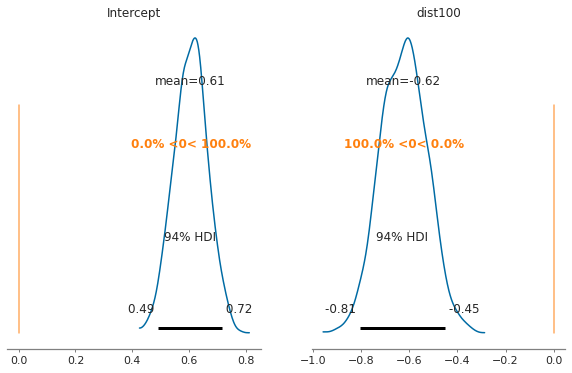

In [64]:
az.plot_posterior(fit2_bmb, ref_val=0, figsize=(10,6));

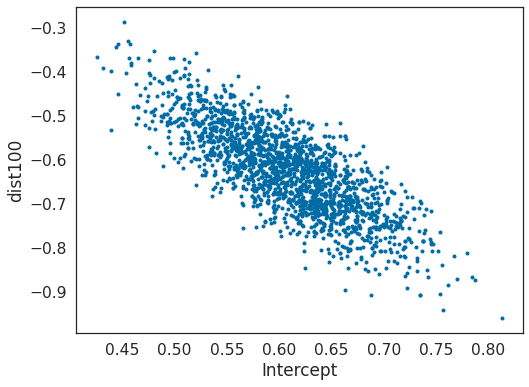

In [65]:
az.plot_pair(fit2_bmb, figsize=(8,6));

In [66]:
posterior_predictive = model2_bmb.predict(fit2_bmb, kind="pps", draws=500)
fit2_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

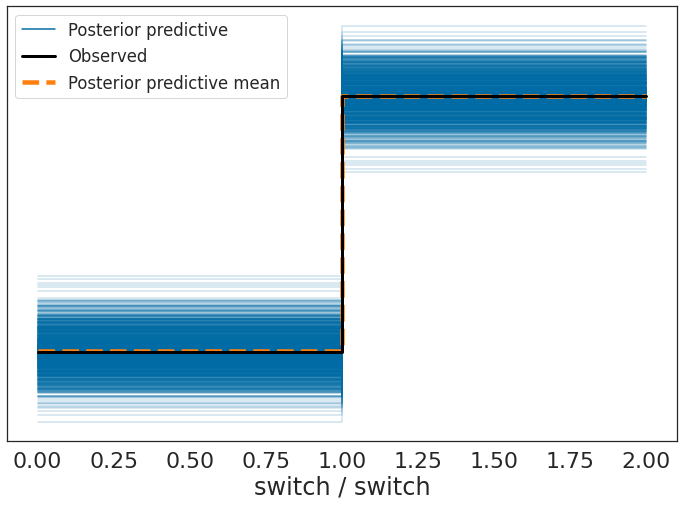

In [67]:
az.plot_ppc(fit2_bmb, figsize=(12,8));

In [68]:
az.loo(fit2_bmb)

Computed from 2000 by 3020 log-likelihood matrix

         Estimate       SE
elpd_loo -2040.09    10.41
p_loo        1.97        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

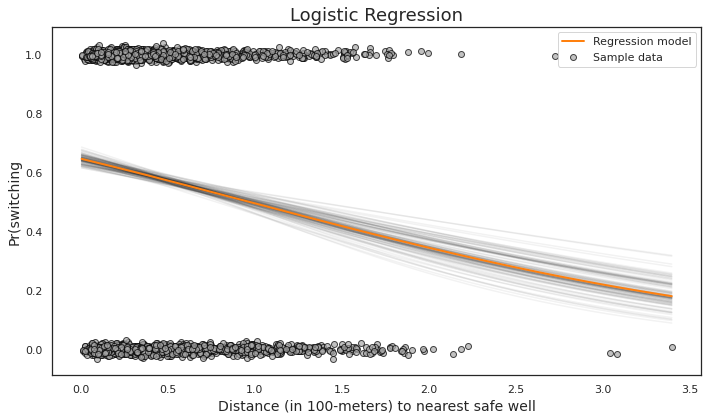

In [69]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(10, 6))

x_axis = xr.DataArray(np.linspace(wells['dist100'].min(), wells['dist100'].max(), 2000), dims=["x_plot"])
mu_pred = fit2_bmb.posterior["Intercept"] + fit2_bmb.posterior["dist100"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, expit(mu_plot.isel(sample=random_subset)), color="black", alpha=0.05)
plt.plot(x_axis, expit(mu_mean), color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Pr(switching', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

## Two predictors

### No interaction

In [70]:
# Initialize the model
model3_bmb = bmb.Model("switch ~ dist100 + arsenic", wells, family="bernoulli")

# Inspect model object
model3_bmb

Formula: switch ~ dist100 + arsenic
Family name: Bernoulli
Link: logit
Observations: 3020
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5.4873)
    dist100 ~ Normal(mu: 0.0, sigma: 6.4982)
    arsenic ~ Normal(mu: 0.0, sigma: 2.2579)

In [71]:
model3_bmb.build()

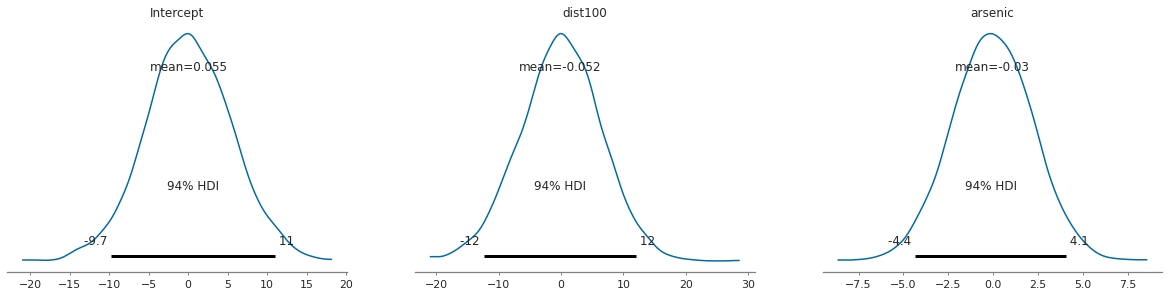

In [72]:
model3_bmb.plot_priors();

In [73]:
print(model3_bmb.backend.model)

Intercept ~ Normal
  dist100 ~ Normal
  arsenic ~ Normal
   switch ~ Bernoulli


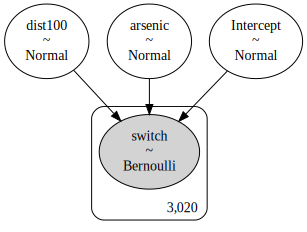

In [74]:
model3_bmb.graph()

In [76]:
fit3_bmb = model3_bmb.fit() # draws=5000, chains=4, cores=None
fit3_bmb

Modeling the probability that switch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [arsenic, dist100, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

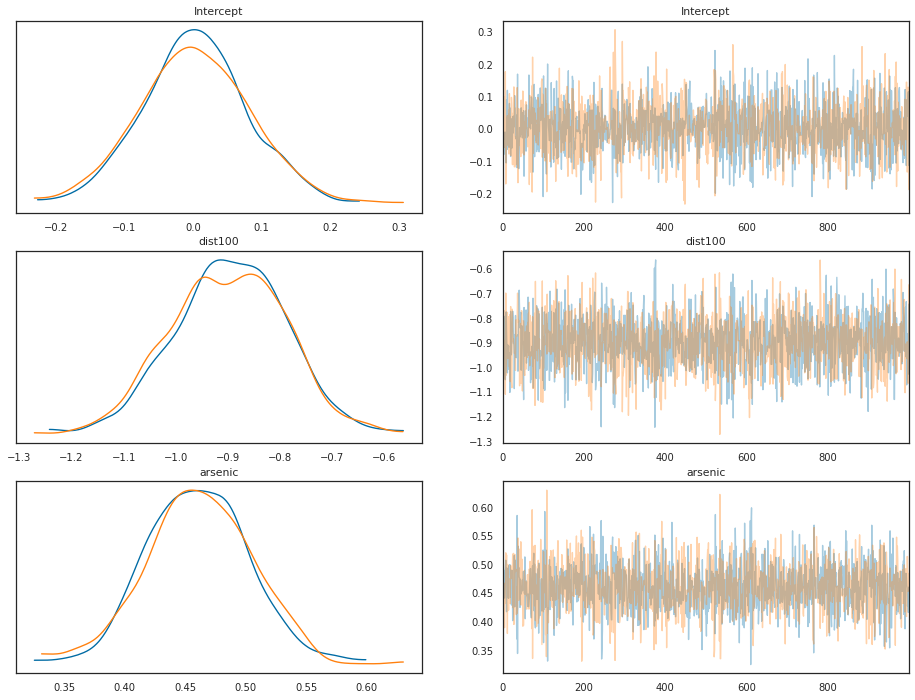

In [77]:
az.plot_trace(fit3_bmb, compact=False, figsize=(16,12));

In [78]:
az.summary(fit3_bmb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.003,0.079,-0.133,0.164,0.002,0.002,2292.0,1401.0,1.0
dist100,-0.898,0.107,-1.086,-0.691,0.002,0.002,2073.0,1479.0,1.0
arsenic,0.461,0.043,0.388,0.547,0.001,0.001,2453.0,1605.0,1.0


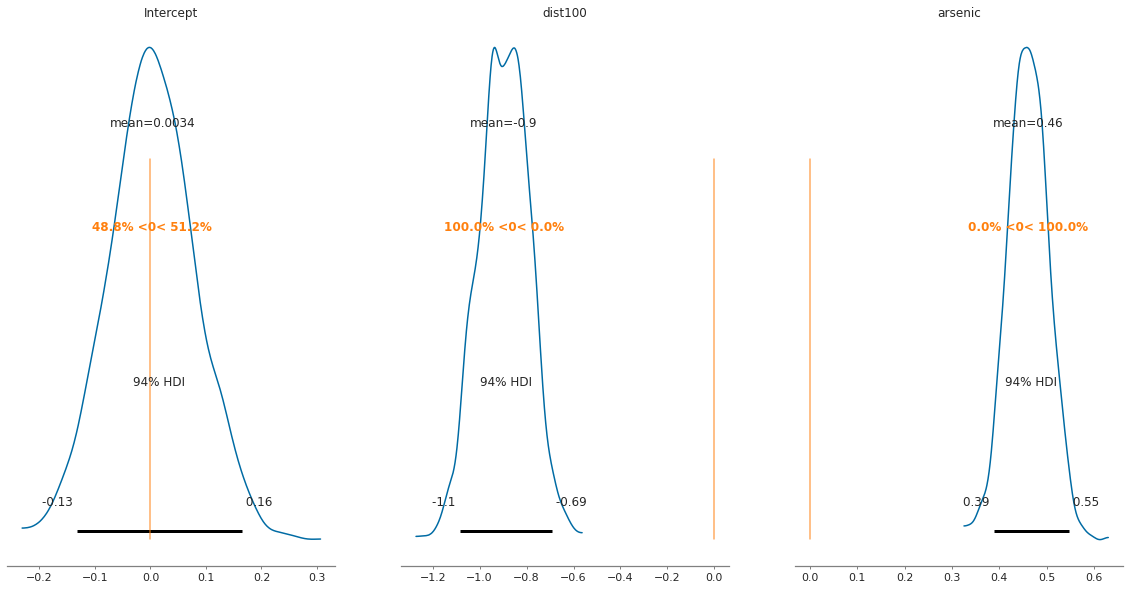

In [79]:
az.plot_posterior(fit3_bmb, ref_val=0, figsize=(20,10));

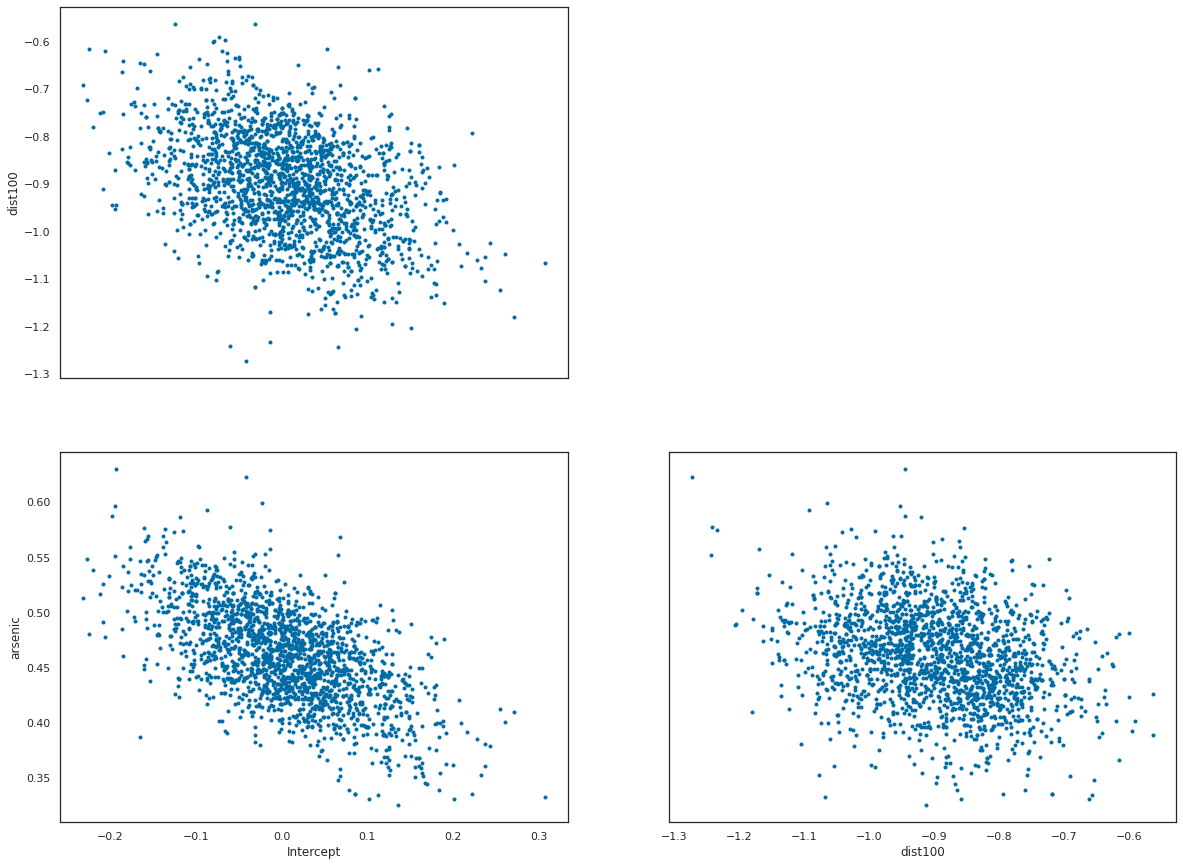

In [80]:
az.plot_pair(fit3_bmb, figsize=(20,15));

In [81]:
posterior_predictive = model3_bmb.predict(fit3_bmb, kind="pps", draws=500)
fit3_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

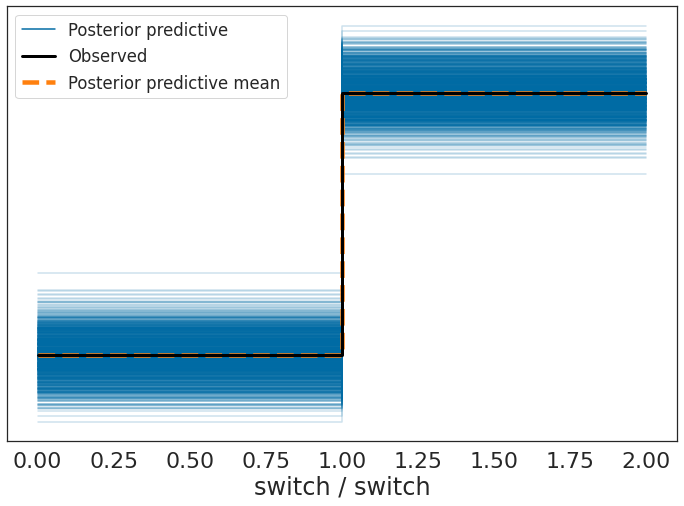

In [82]:
az.plot_ppc(fit3_bmb, figsize=(12,8));

In [83]:
az.loo(fit3_bmb)

Computed from 2000 by 3020 log-likelihood matrix

         Estimate       SE
elpd_loo -1968.59    15.65
p_loo        3.37        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

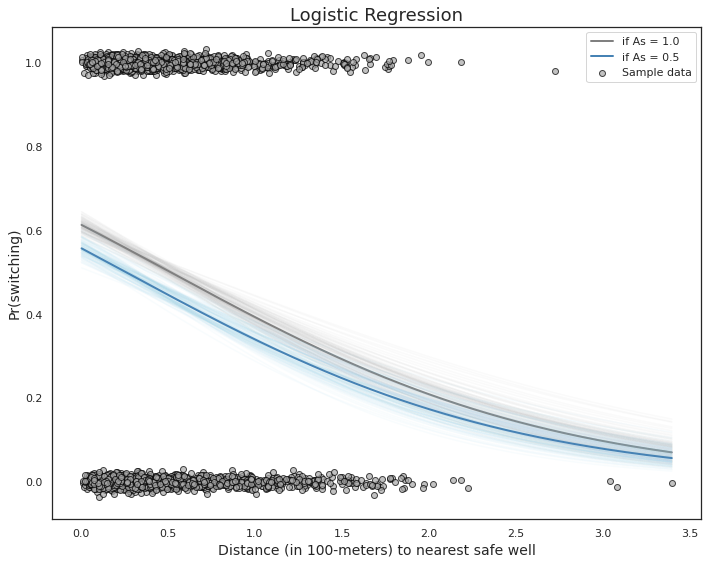

In [84]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['dist100'].min(), wells['dist100'].max(), 2000), dims=["x_plot"])
plt.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# As = 1.0: Posterior regression lines
mu_pred_As1 = fit3_bmb.posterior["Intercept"] + (fit3_bmb.posterior["dist100"] * x_axis) + (fit3_bmb.posterior["arsenic"] * 1.0)
mu_mean_As1 = mu_pred_As1.mean(dim=("chain", "draw"))
mu_plot_As1 = mu_pred_As1.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As1.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As1.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As1), color="gray", lw=2.0, label='if As = 1.0')

# As = 0.5: Posterior regression lines
mu_pred_As0pt5 = fit3_bmb.posterior["Intercept"] + (fit3_bmb.posterior["dist100"] * x_axis) + (fit3_bmb.posterior["arsenic"] * 0.5)
mu_mean_As0pt5 = mu_pred_As0pt5.mean(dim=("chain", "draw"))
mu_plot_As0pt5 = mu_pred_As0pt5.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As0pt5.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As0pt5.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As0pt5), color="steelblue", lw=2.0, label='if As = 0.5')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

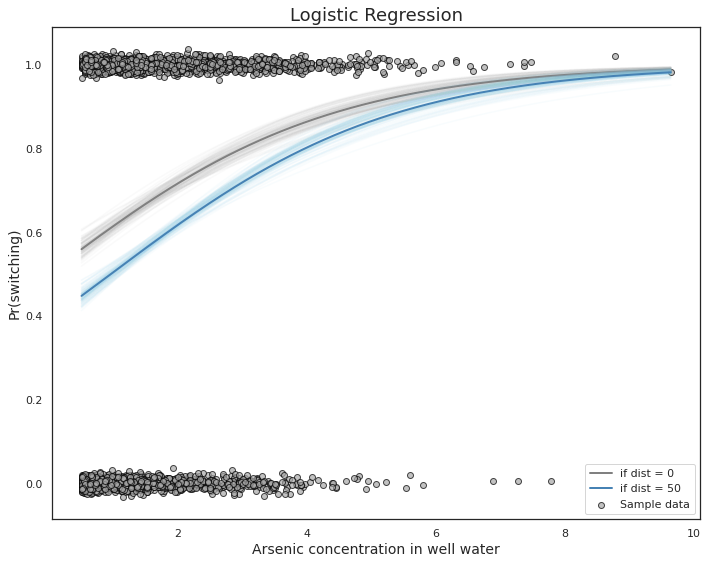

In [85]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 2000), dims=["x_plot"])
plt.scatter(wells.arsenic, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# dist = 0 meters: Posterior regression lines
mu_pred_dist0 = fit3_bmb.posterior["Intercept"] + (fit3_bmb.posterior["dist100"] * 0.0) + (fit3_bmb.posterior["arsenic"] * x_axis)
mu_mean_dist0 = mu_pred_dist0.mean(dim=("chain", "draw"))
mu_plot_dist0 = mu_pred_dist0.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist0.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist0.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist0), color="gray", lw=2.0, label='if dist = 0')

# dist = 50 meters: Posterior regression lines
mu_pred_dist50 = fit3_bmb.posterior["Intercept"] + (fit3_bmb.posterior["dist100"] * 0.5) + (fit3_bmb.posterior["arsenic"] * x_axis)
mu_mean_dist50 = mu_pred_dist50.mean(dim=("chain", "draw"))
mu_plot_dist50 = mu_pred_dist50.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist50.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist50.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist50), color="steelblue", lw=2.0, label='if dist = 50')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Arsenic concentration in well water', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression', fontsize=18)

fig.tight_layout();

### Interaction

In [86]:
# Initialize the model
model4_bmb = bmb.Model("switch ~ dist100 + arsenic + dist100:arsenic", wells, family="bernoulli")

# Inspect model object
model4_bmb

Formula: switch ~ dist100 + arsenic + dist100:arsenic
Family name: Bernoulli
Link: logit
Observations: 3020
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 5.8732)
    dist100 ~ Normal(mu: 0.0, sigma: 6.4982)
    arsenic ~ Normal(mu: 0.0, sigma: 2.2579)
    dist100:arsenic ~ Normal(mu: 0.0, sigma: 2.3882)

In [87]:
model4_bmb.build()

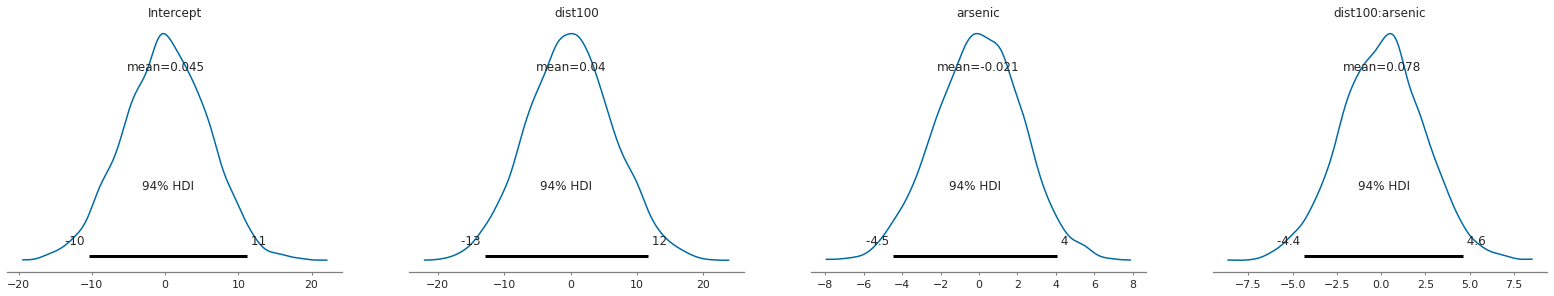

In [88]:
model4_bmb.plot_priors();

In [89]:
print(model4_bmb.backend.model)

      Intercept ~ Normal
        dist100 ~ Normal
        arsenic ~ Normal
dist100:arsenic ~ Normal
         switch ~ Bernoulli


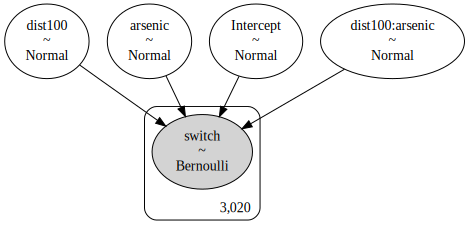

In [90]:
model4_bmb.graph()

In [91]:
fit4_bmb = model4_bmb.fit() # draws=5000, chains=4, cores=None
fit4_bmb

Modeling the probability that switch==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [dist100:arsenic, arsenic, dist100, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

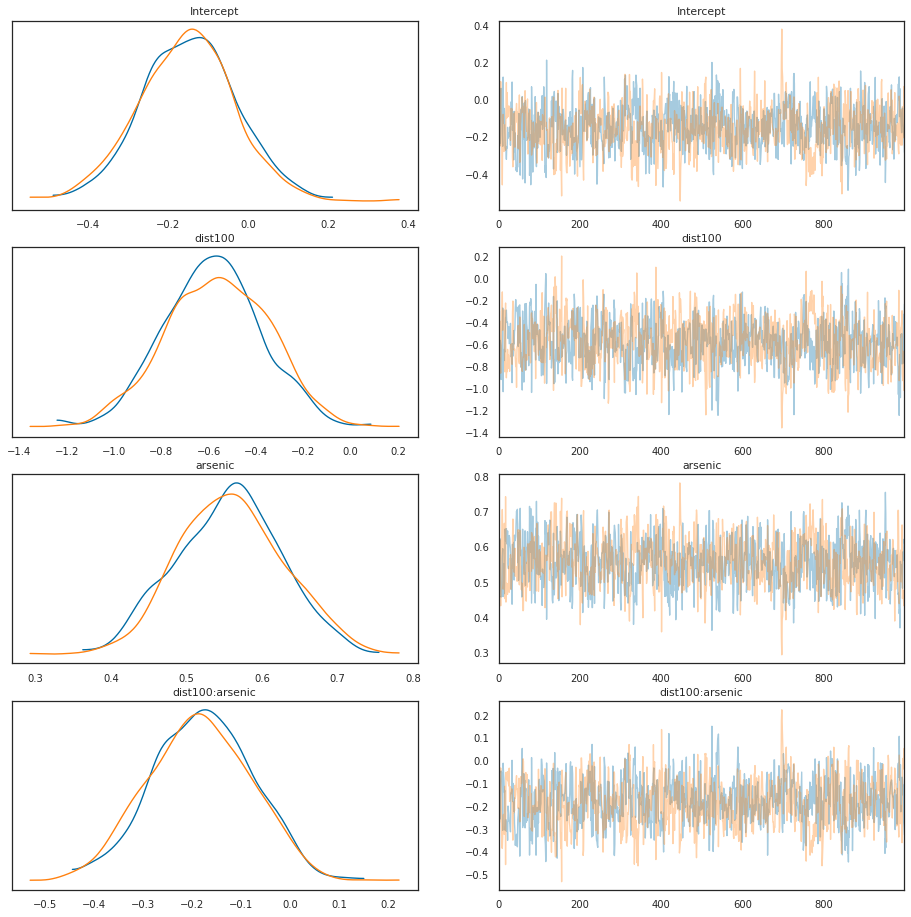

In [92]:
az.plot_trace(fit4_bmb, compact=False, figsize=(16,16));

In [93]:
az.summary(fit4_bmb)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.151,0.118,-0.364,0.083,0.005,0.004,470.0,775.0,1.0
dist100,-0.574,0.214,-0.957,-0.169,0.010,0.007,506.0,872.0,1.0
arsenic,0.558,0.069,0.436,0.692,0.003,0.002,487.0,1033.0,1.0
dist100:arsenic,-0.180,0.104,-0.369,0.010,0.005,0.004,382.0,775.0,1.0


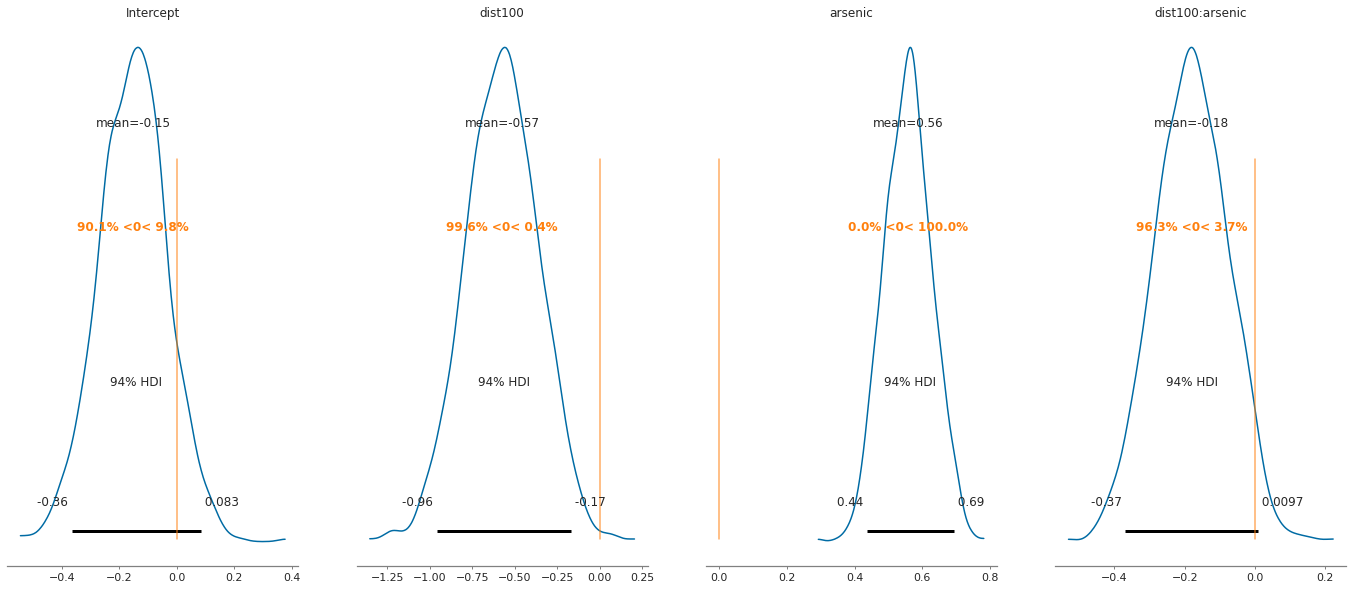

In [94]:
az.plot_posterior(fit4_bmb, ref_val=0, figsize=(24,10));

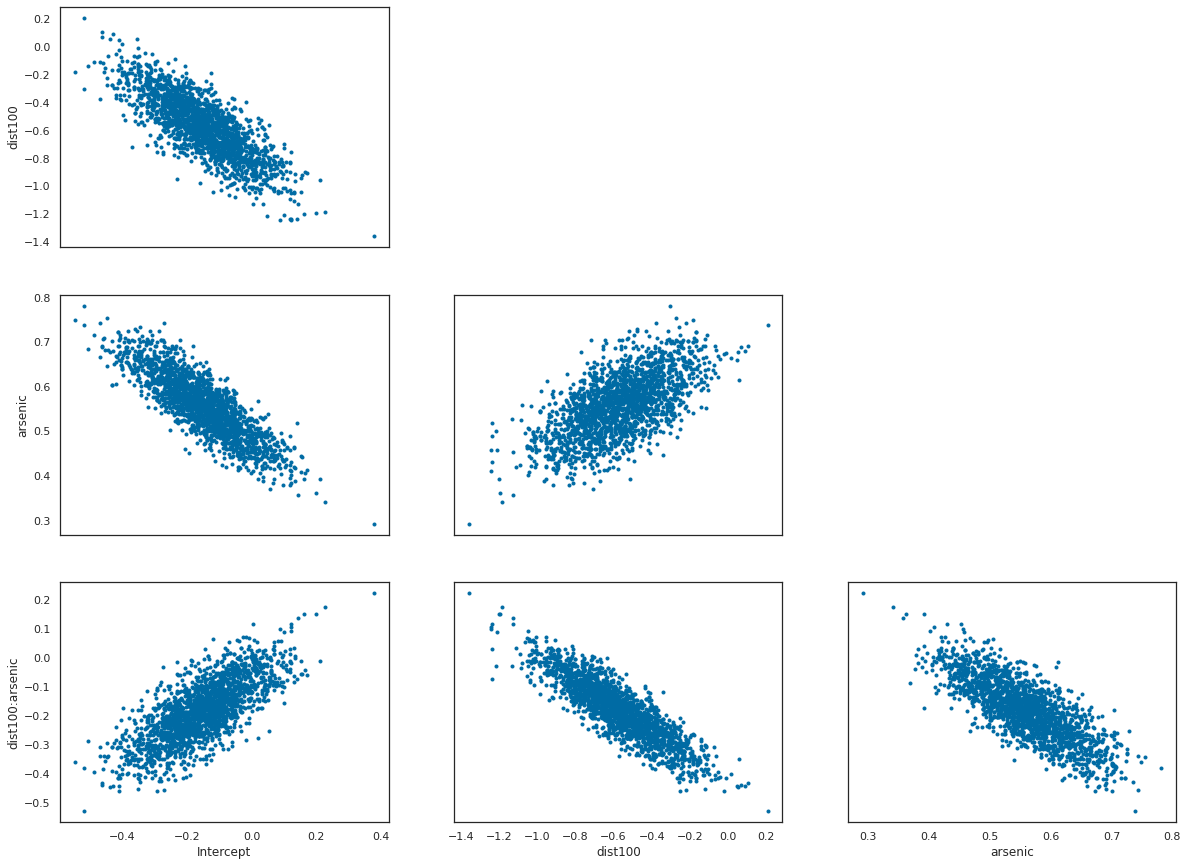

In [95]:
az.plot_pair(fit4_bmb, figsize=(20,15));

In [96]:
posterior_predictive = model4_bmb.predict(fit4_bmb, kind="pps", draws=500)
fit4_bmb

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

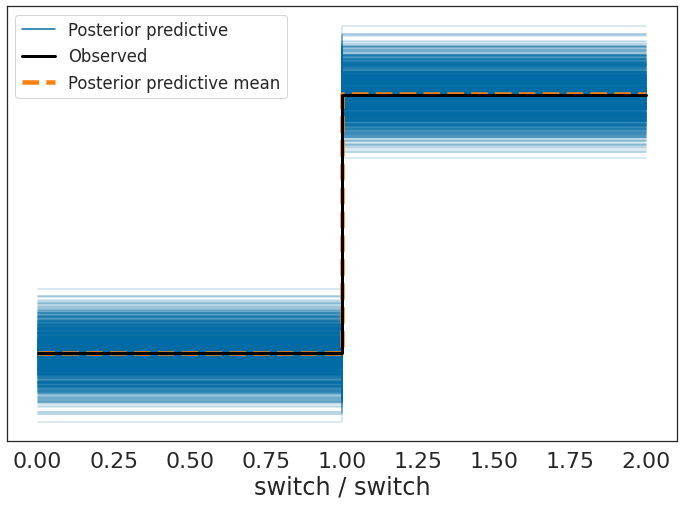

In [97]:
az.plot_ppc(fit4_bmb, figsize=(12,8));

In [98]:
az.loo(fit4_bmb)

Computed from 2000 by 3020 log-likelihood matrix

         Estimate       SE
elpd_loo -1968.05    15.86
p_loo        4.43        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3020  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

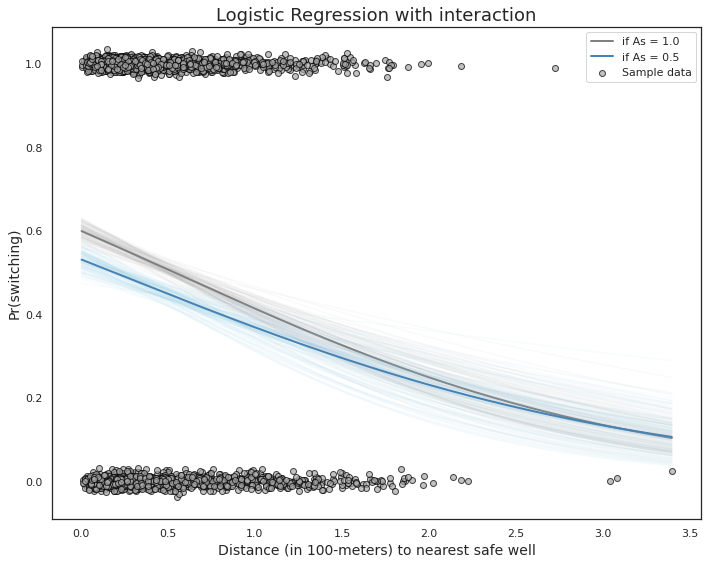

In [99]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['dist100'].min(), wells['dist100'].max(), 2000), dims=["x_plot"])
plt.scatter(wells.dist100, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# As = 1.0: Posterior regression lines
mu_pred_As1 = fit4_bmb.posterior["Intercept"] + (fit4_bmb.posterior["dist100"] * x_axis) + (fit4_bmb.posterior["arsenic"] * 1.0) + (fit4_bmb.posterior["dist100:arsenic"] * x_axis * 1.0)
mu_mean_As1 = mu_pred_As1.mean(dim=("chain", "draw"))
mu_plot_As1 = mu_pred_As1.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As1.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As1.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As1), color="gray", lw=2.0, label='if As = 1.0')

# As = 0.5: Posterior regression lines
mu_pred_As0pt5 = fit4_bmb.posterior["Intercept"] + (fit4_bmb.posterior["dist100"] * x_axis) + (fit4_bmb.posterior["arsenic"] * 0.5) + (fit4_bmb.posterior["dist100:arsenic"] * x_axis * 0.5)
mu_mean_As0pt5 = mu_pred_As0pt5.mean(dim=("chain", "draw"))
mu_plot_As0pt5 = mu_pred_As0pt5.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_As0pt5.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_As0pt5.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_As0pt5), color="steelblue", lw=2.0, label='if As = 0.5')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Distance (in 100-meters) to nearest safe well', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression with interaction', fontsize=18)

fig.tight_layout();

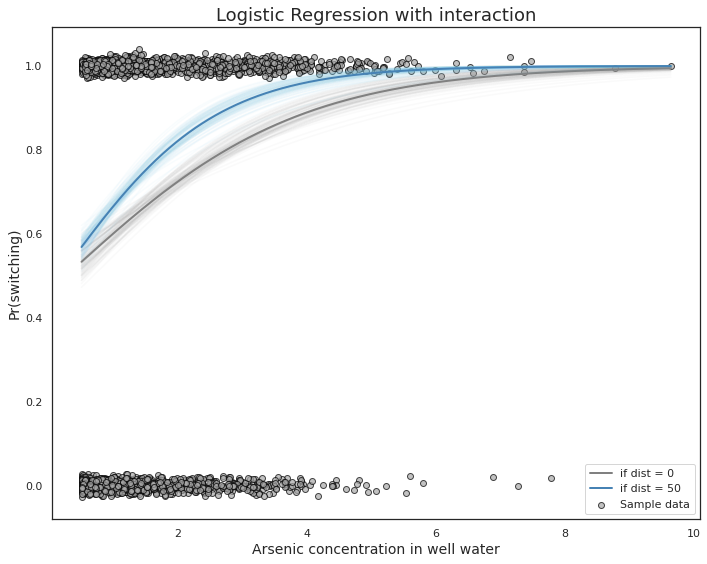

In [100]:
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot of data points
x_axis = xr.DataArray(np.linspace(wells['arsenic'].min(), wells['arsenic'].max(), 2000), dims=["x_plot"])
plt.scatter(wells.arsenic, rand_jitter(wells.switch), edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')

# dist = 0 meters: Posterior regression lines
mu_pred_dist0 = fit4_bmb.posterior["Intercept"] + (fit4_bmb.posterior["dist100"] * 0.0) + (fit4_bmb.posterior["arsenic"] * x_axis) + (fit4_bmb.posterior["arsenic"] * x_axis * 0.0)
mu_mean_dist0 = mu_pred_dist0.mean(dim=("chain", "draw"))
mu_plot_dist0 = mu_pred_dist0.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist0.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist0.isel(sample=random_subset)), color="darkgray", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist0), color="gray", lw=2.0, label='if dist = 0')

# dist = 50 meters: Posterior regression lines
mu_pred_dist50 = fit4_bmb.posterior["Intercept"] + (fit4_bmb.posterior["dist100"] * 0.0) + (fit4_bmb.posterior["arsenic"] * x_axis) + (fit4_bmb.posterior["arsenic"] * x_axis * 0.5)
mu_mean_dist50 = mu_pred_dist50.mean(dim=("chain", "draw"))
mu_plot_dist50 = mu_pred_dist50.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_dist50.sample)))[:100]

plt.plot(x_axis, expit(mu_plot_dist50.isel(sample=random_subset)), color="skyblue", alpha=0.05)
plt.plot(x_axis, expit(mu_mean_dist50), color="steelblue", lw=2.0, label='if dist = 50')

# Plot title and axis labels
ax.set_ylabel('Pr(switching)', fontsize=14)
ax.set_xlabel('Arsenic concentration in well water', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Logistic Regression with interaction', fontsize=18)

fig.tight_layout();

## Model comparison

In [101]:
models_dict = {
    "model2": fit2_bmb,
    "model3": fit3_bmb,
    "model4": fit4_bmb
}
df_compare = az.compare(models_dict)
df_compare.round(2)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model4,0,-1968.05,4.43,0.00,0.76,15.86,0.00,False,log
model3,1,-1968.59,3.37,0.53,0.17,15.65,1.92,False,log
model2,2,-2040.09,1.97,72.04,0.07,10.41,12.41,False,log


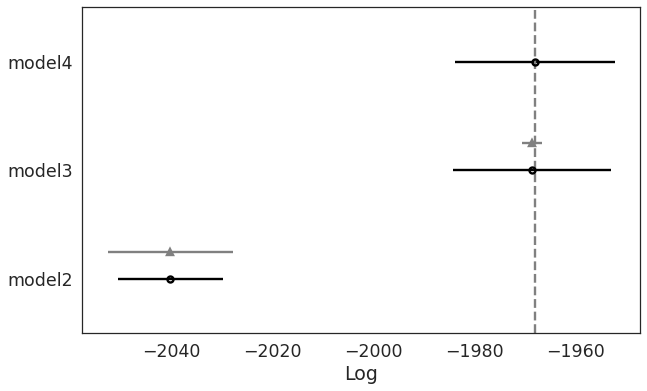

In [102]:
az.plot_compare(df_compare, insample_dev=False, figsize=(10,6));